In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [16]:
image_width = 450
image_height = 450
batch = 32
channels = 3
train_size = 0.8
test_size = 0.1
epochs = 30

In [4]:
leafs_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\Medicinal Plant Identification\Indian Medicinal Leaves Image Datasets\Smaller Leaf dataset", shuffle=True, image_size=(image_width,image_height), batch_size=batch)

Found 417 files belonging to 4 classes.


In [5]:
leafs_classes= leafs_dataset.class_names
# plant_classes = plants_dataset.class_names
leafs_classes

['Mint', 'Tulsi', 'Turmeric', 'camphor']

(32, 450, 450, 3)
[0 3 2 0 0 1 1 0 1 2 3 2 1 2 3 1 1 0 1 1 3 0 0 1 3 1 0 3 1 0 3 2]


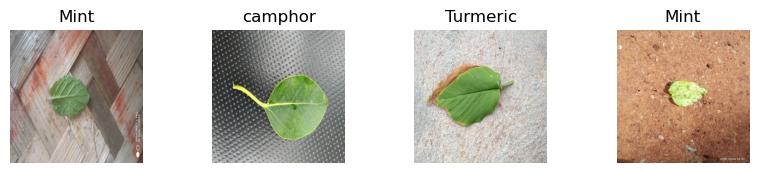

In [7]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in leafs_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range (4):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(leafs_classes[labels_batch[i]])
        plt.axis('off')

In [8]:
print(len(leafs_dataset)*train_size)
print(len(leafs_dataset)*test_size)

11.200000000000001
1.4000000000000001


In [9]:
def get_dataset(ds, train_split=0.7, val_split=0.15, test_split = 0.1, shuffle=True, shuffle_size=100):
  #assert(train_split+val_split+test_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12) 

  train_size = int(train_split*ds_size)
  valid_size = int(val_split*ds_size)
  leafs_train_dataset = ds.take(train_size)
  leafs_val_dataset = ds.skip(train_size).take(valid_size)
  leafs_test_dataset = ds.skip(train_size).skip(valid_size)
  
  return leafs_train_dataset, leafs_val_dataset, leafs_test_dataset

In [10]:
train_ds, val_ds, test_ds = get_dataset(leafs_dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

9
2
3


In [11]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 450, 450, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(image_width,image_height)
])


data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [13]:
input_shape = (batch, image_width,image_height,channels)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_aug,
    #convolutional layers
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    #flattening layers
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 450, 450, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 450, 450, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 448, 448, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 224, 224, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 222, 222, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 111, 111, 64)        0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    batch_size = batch,
    validation_data = val_ds,
    verbose = 1,
    epochs = epochs
)

Epoch 1/30


9/9 [==============================] - 116s 11s/step - loss: 1.5233 - accuracy: 0.3580 - val_loss: 1.3253 - val_accuracy: 0.3438
Epoch 2/30
9/9 [==============================] - 106s 11s/step - loss: 1.2595 - accuracy: 0.4125 - val_loss: 1.2719 - val_accuracy: 0.3438
Epoch 3/30
9/9 [==============================] - 114s 12s/step - loss: 1.2388 - accuracy: 0.4201 - val_loss: 1.0716 - val_accuracy: 0.6250
Epoch 4/30
9/9 [==============================] - 97s 10s/step - loss: 1.2168 - accuracy: 0.4086 - val_loss: 1.3195 - val_accuracy: 0.4062
Epoch 5/30
9/9 [==============================] - 106s 11s/step - loss: 1.1729 - accuracy: 0.4514 - val_loss: 1.2042 - val_accuracy: 0.3906
Epoch 6/30
9/9 [==============================] - 104s 11s/step - loss: 1.1757 - accuracy: 0.4340 - val_loss: 1.0203 - val_accuracy: 0.4844
Epoch 7/30
9/9 [==============================] - 97s 10s/step - loss: 1.1187 - accuracy: 0.4825 - val_loss: 1.0437 - val_accuracy: 0.5469
Epoch 8/30
9/9 [=================

In [18]:
scores = model.evaluate(test_ds)
scores

3/3 [==============================] - 14s 2s/step - loss: 0.5549 - accuracy: 0.7708


[0.5548573136329651, 0.7708333134651184]

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

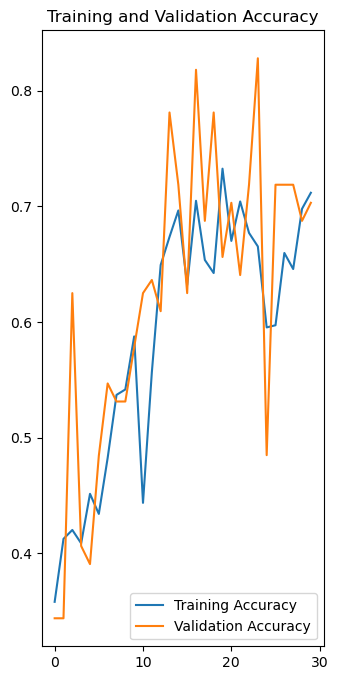

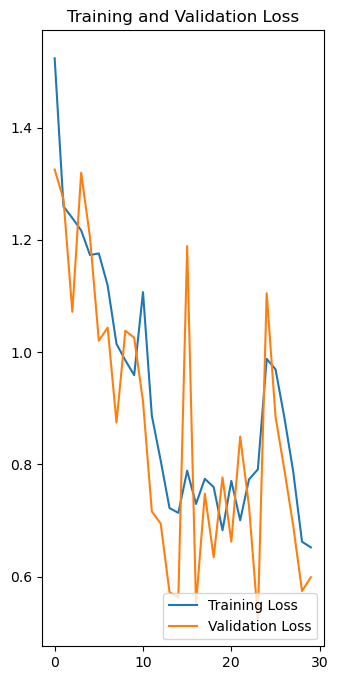

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label:  Mint
1/1 [==============================] - 2s 2s/step
Predicted Label:  Mint


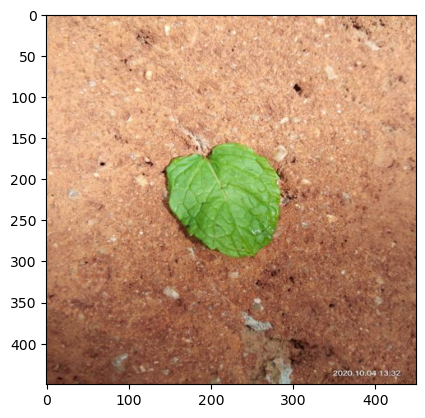

In [23]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", leafs_classes[first_label])

    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ',leafs_classes[np.argmax(batch_prediction[0])])
    confidence = round(100*(np.max(batch_prediction)))

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = leafs_classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 129ms/step


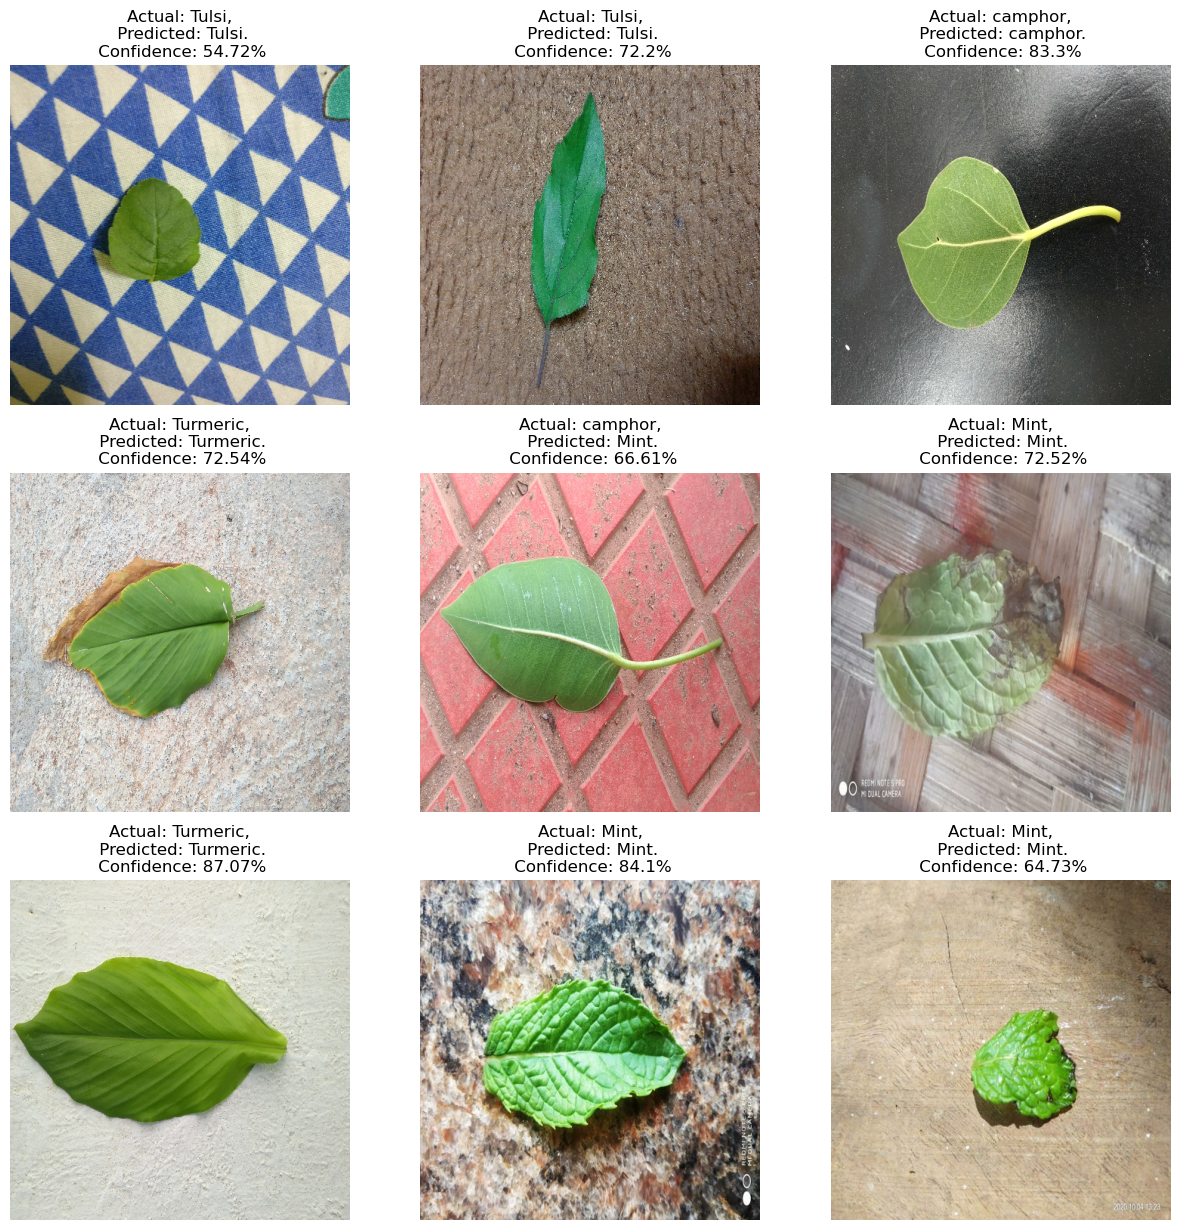

In [26]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = leafs_classes[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [28]:
import os
model_version=max([int(i) for i in os.listdir("./Successful_Models") + [0]])+1
model.save(f"./Successful_Models/{model_version}")

INFO:tensorflow:Assets written to: ./Successful_Models/1\assets


INFO:tensorflow:Assets written to: ./Successful_Models/1\assets


In [29]:
model.save("../leafs.h5")

c:\Users\shail\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
